# Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks

In this notebook, we will demostrate how to implement *Model-Agnostic Meta-Learning (MAML)* in FastEstimator.
We will train a simple sinusoid regression model using *MAML* for a 10-shot regression task.
The objective of *MAML* is to learn a model that is trained on a larger set of related tasks so that the trained model can quickly adapt to the given task.

In [1]:
import numpy as np
import tensorflow as tf
import fastestimator as fe

In [2]:
from tensorflow.keras import layers, losses
from tensorflow.keras import Sequential, Model

In [ ]:
#parameter
BATCH_SIZE = 25
EPOCHS = 1
STEPS_PER_EPOCH = 20000

## Step 1: Create Data Pipeline

First, we will create data pipeline that will yield a batch of sinusoid regression tasks where each task yields 10 data points of *x* and *y* defined by the following equation:

$y = amplitude * sin(x + phase)$
where $amplitude$, $phase$, and $x$ are randomly chosen for each task.

The dimension for each batch is *(number of task, number of sample, 1)*

In [3]:
def generate_random_sine(amp_range=[0.1, 5.0], phase_range=[0, np.pi], x_range=[-5.0, 5.0], K=10):
    while True:
        a = np.random.uniform(amp_range[0], amp_range[1])
        b = np.random.uniform(phase_range[0], phase_range[1])
        x = np.random.uniform(x_range[0], x_range[1], 2*K).astype(np.float32)
        y = a * np.sin(x + b).astype(np.float32)
        yield {"x_meta_train": np.expand_dims(x[:K], axis=-1),
               "x_meta_test": np.expand_dims(x[K:], axis=-1), 
               "y_meta_train": np.expand_dims(y[:K], axis=-1),
               "y_meta_test": np.expand_dims(y[K:], axis=-1),
               "amp":a, 
               "phase":b}

In [4]:
sine_test_data = next(generate_random_sine())

In [8]:
pipeline = fe.Pipeline(
    data={"train":generate_random_sine},
    batch_size=BATCH_SIZE
)

## Step 2: Define Network
For the regression task, we use a simple Multi-Layer Perceptron (MLP) as described in the paper.

In [9]:
def build_sine_model():
    mdl = Sequential()
    mdl.add(layers.Dense(40, input_shape=(1,), activation="relu"))
    mdl.add(layers.Dense(40, activation="relu"))
    mdl.add(layers.Dense(1))
    return mdl


meta_model = fe.build(
    model_def=build_sine_model,
    model_name="meta_model",
    loss_name="meta_loss",
    optimizer="adam"
)

### Define Operators
The training scheme of *MAML* is as follows:

Given a meta train batch $D^{tr}$, a meta test batch $D^{test}$, and a meta model weight $\theta$,
1. Compute $\mathcal{L}\left(D^{tr}, \theta\right)$
2. Compute $\nabla_{\theta}\mathcal{L}\left(D^{tr}, \theta\right)$
3. Define a tentative model weight $\phi$ as $\theta - \beta\nabla_{\theta}\mathcal{L}\left(D^{tr}, \theta\right)$ where $\beta$ is an inner learning rate.
4. Compute $\mathcal{L}\left(D^{test}, \phi\right)$
5. Compute $\nabla_{\theta}\mathcal{L}\left(D^{test}, \phi\right)$

Note that the gradient computed in step 5 is the second order gradient because
$\nabla_{\theta}\mathcal{L}\left(D^{test}, \phi\right) = \nabla_{\theta}\mathcal{L}\left(D^{test}, \theta - \beta\nabla_{\theta}\mathcal{L}\left(D^{tr}, \theta\right)\right)$

We have to define the following operators to support the meta learning:
* MetaModelOp to apply *ModelOp* to each task
* MetaMSE to apply *MeanSquaredError* to each task
* InnerGradientOp to compute the first order gradient for each task
* InnerUpdateOp to obtain $\phi$
* MetaForwardOp to compute the forward pass of $\phi$ on $D^{test}$

In [14]:
from fastestimator.op import TensorOp
from fastestimator.op.tensorop import ModelOp
from fastestimator.op.tensorop import UpdateOp, Gradients
from fastestimator.op.tensorop.loss import MeanSquaredError, Loss        

class MetaModelOp(ModelOp):
    def _single_forward(self, data):
        return self.model(data, training=True)
    
    def forward(self, data, state):        
        out = tf.map_fn(fn=self._single_forward, elems=data, dtype=tf.float32)
        return out
    
class MetaMSE(MeanSquaredError):
    def forward(self, data, state):
        true, pred = data
        out = self.loss_obj(true, pred)
        return tf.reduce_mean(out, axis=1)

    
class InnerGradientOp(TensorOp):
    def __init__(self, loss, model, outputs):
        super().__init__(inputs=loss, outputs=outputs, mode="train")
        self.model = model
        
    def forward(self, data, state):
        loss = data
        tape = state['tape']
        gradients = tape.gradient(loss, self.model.trainable_variables)
        return gradients, self.model.trainable_variables     

class InnerUpdateOp(TensorOp):
    def __init__(self, inputs, outputs, inner_lr):
        super().__init__(inputs=inputs, outputs=outputs, mode="train")
        self.inner_lr = inner_lr
        
    def forward(self, data, state):
        g, v = data
        return [v_ - self.inner_lr * g_ for g_, v_ in zip(g, v)]

class MetaForwardOp(TensorOp):
    def forward(self, data, state):
        x0, model_var = data
        
        def _single_forward(x):
            out = tf.nn.relu(tf.matmul(x, model_var[0]) + model_var[1])
            for i in range(2, len(model_var) - 2, 2):
                out = tf.nn.relu(tf.matmul(out, model_var[2]) + model_var[3])        
            out = tf.matmul(out, model_var[-2]) + model_var[-1]
            return out
        
        return tf.map_fn(_single_forward, elems=x0, dtype=tf.float32)

Given these operators, we need to put everything together in *Network*.

In [15]:
network = fe.Network(
    ops=[
        MetaModelOp(inputs="x_meta_train", outputs="y_meta_pred", model=meta_model),
        MetaMSE(inputs=("y_meta_train", "y_meta_pred"), outputs="inner_loss"),
        InnerGradientOp(loss="inner_loss", model=meta_model, outputs=("inner_grad", "model_var")),
        InnerUpdateOp(inputs=("inner_grad", "model_var"), outputs="model_var", inner_lr=1e-3),
        MetaForwardOp(inputs=("x_meta_test", "model_var"), outputs="y_pred"),
        MetaMSE(inputs=("y_meta_test", "y_pred"), outputs="meta_loss"),
        Gradients(loss="meta_loss", models=meta_model, outputs="meta_grad"),
        UpdateOp(model=meta_model, gradients="meta_grad")
    ]
)

## Step 3: Define Estimator
Given *Pipeline* and *Network*, we put these together in *Estimator*

In [17]:
estimator = fe.Estimator(
    network=network,
    pipeline=pipeline,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH
)

In [18]:
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Warn: No ModelSaver Trace detected. Models will not be saved.
FastEstimator-Start: step: 0; total_train_steps: 20000; meta_model_lr: 0.001; 
FastEstimator-Train: step: 0; meta_loss: 5.723891; inner_loss: 6.9464946; 
FastEstimator-Train: step: 100; meta_loss: 3.4250093; inner_loss: 2.9725184; examples/sec: 370.3; progress: 0.5%; 
FastEstimator-Train: step: 200; meta_loss: 3.6458304; inner_loss: 4.013458; examples/sec: 377.7; progress: 1.0%; 
FastEstimator-Train: step: 300; meta_loss: 3.0723948; inner_loss: 3.707258; examples/sec: 377.7; progr

FastEstimator-Train: step: 6000; meta_loss: 1.610773; inner_loss: 1.94066; examples/sec: 379.5; progress: 30.0%; 
FastEstimator-Train: step: 6100; meta_loss: 2.3705523; inner_loss: 2.6015983; examples/sec: 377.6; progress: 30.5%; 
FastEstimator-Train: step: 6200; meta_loss: 3.6479864; inner_loss: 3.4792807; examples/sec: 379.4; progress: 31.0%; 
FastEstimator-Train: step: 6300; meta_loss: 2.3008645; inner_loss: 2.7936928; examples/sec: 378.6; progress: 31.5%; 
FastEstimator-Train: step: 6400; meta_loss: 2.5303686; inner_loss: 2.9379578; examples/sec: 375.0; progress: 32.0%; 
FastEstimator-Train: step: 6500; meta_loss: 2.9302416; inner_loss: 3.420107; examples/sec: 371.2; progress: 32.5%; 
FastEstimator-Train: step: 6600; meta_loss: 3.4646788; inner_loss: 3.4846115; examples/sec: 372.1; progress: 33.0%; 
FastEstimator-Train: step: 6700; meta_loss: 2.819759; inner_loss: 2.6378808; examples/sec: 371.4; progress: 33.5%; 
FastEstimator-Train: step: 6800; meta_loss: 3.1392748; inner_loss: 3.

FastEstimator-Train: step: 13100; meta_loss: 2.774506; inner_loss: 2.8231378; examples/sec: 378.3; progress: 65.5%; 
FastEstimator-Train: step: 13200; meta_loss: 3.799182; inner_loss: 3.9009297; examples/sec: 380.2; progress: 66.0%; 
FastEstimator-Train: step: 13300; meta_loss: 2.6867194; inner_loss: 2.9257648; examples/sec: 377.6; progress: 66.5%; 
FastEstimator-Train: step: 13400; meta_loss: 3.207861; inner_loss: 3.3840263; examples/sec: 378.7; progress: 67.0%; 
FastEstimator-Train: step: 13500; meta_loss: 3.0611348; inner_loss: 2.9313369; examples/sec: 378.7; progress: 67.5%; 
FastEstimator-Train: step: 13600; meta_loss: 2.5197492; inner_loss: 2.704917; examples/sec: 380.1; progress: 68.0%; 
FastEstimator-Train: step: 13700; meta_loss: 3.39369; inner_loss: 3.429712; examples/sec: 376.3; progress: 68.5%; 
FastEstimator-Train: step: 13800; meta_loss: 3.1631653; inner_loss: 3.4606051; examples/sec: 376.7; progress: 69.0%; 
FastEstimator-Train: step: 13900; meta_loss: 2.641903; inner_lo

## Evaluate the Meta Model
Now let's evaluate how good the trained meta model is on the evaluation set that contains only 10 data points of $x$ and $y$.

In [19]:
import matplotlib
import matplotlib.pyplot as plt

The orange crosses are available sample data points and the blue curve is the underlying sinusoid curve.
The green curve is a curve fitted by the meta model without any adaptation.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



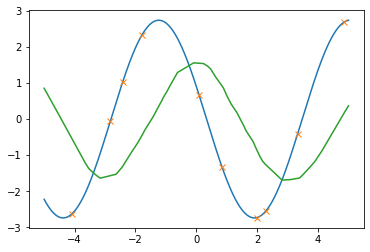

In [20]:
y_sample = sine_test_data["y_meta_train"][:10].astype(np.float32)
x_sample = sine_test_data["x_meta_train"][:10].astype(np.float32)
plt.figure()
x_uniform = np.arange(start=-5, stop=5, step=.0001)
y_uniform = sine_test_data['amp'] * np.sin(x_uniform + sine_test_data['phase'])
plt.plot(x_uniform, y_uniform)
plt.plot(x_sample, y_sample, 'x')
y_pred = meta_model(np.expand_dims(x_uniform, axis=-1))
plt.plot(x_uniform, y_pred)

Now we will adapt the meta model to our given sinusoid regression task with only 10 gradient steps.

In [35]:
ds = tf.data.Dataset.from_tensor_slices((np.expand_dims(x_sample,axis=-1), np.expand_dims(y_sample,axis=-1)))
ds = ds.batch(10)

In [36]:
def build_task_model(meta_model):
    m = tf.keras.models.clone_model(meta_model)
    m.set_weights(meta_model.get_weights())
    return m

In [ ]:
task_model = build_task_model(meta_model)
loss_obj = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(2e-2)
for _ in range(10):
    for ex in ds:
        x_tr = ex[0]
        y_tr = ex[1]
        with tf.GradientTape() as t:
            logit = task_model(x_tr, training=True)
            loss = loss_obj(y_tr, logit)
        g = t.gradient(loss, task_model.trainable_variables)
        opt.apply_gradients(zip(g, task_model.trainable_variables))

The blue curve and the green curve corresponds to the ground truth and the initial fitted curve from the unadapted model respectively. The red curve is the output of the adapted model. 
We can see that the red curve can approximate the blue curve reasonably well with few gradient update.

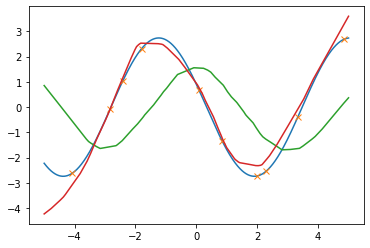

In [38]:
plt.figure()
plt.plot(x_uniform, y_uniform)
plt.plot(x_sample, y_sample, 'x')
plt.plot(x_uniform, y_pred)
y_pred_after = task_model(np.expand_dims(x_uniform, axis=-1))
plt.plot(x_uniform, y_pred_after)